# 2D Tile Placement Testing & Visualization

This notebook tests various solvers for the 2D tile placement problem and provides visualization and validation of the solutions.

## Methods Compared:
- Neural Solver (deep reinforcement learning)
- Greedy Solver 
- ACO (Ant Colony Optimization) Solver
- Exact Solver (for small instances)

Each solution is validated and visualized as a grid showing tile placements.

In [1]:
#!/usr/bin/env python3
"""
Test the neural model with make_dataset and compare with baseline methods.
Includes visualization and validation of solutions.
"""

import time
import random
import numpy as np
import torch
import csv
from datetime import datetime
from collections import namedtuple
from typing import List, Dict, Any, Optional, Tuple
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns

# Import modules from the project
from train import make_dataset, evaluate_instance
from net import NeuralSolver, TileCNN, masked_softmax
from env import (precompute_tile_embeddings, make_synthetic_tiles, TilePlacementEnv, 
                layout_bbox, build_step_batch_from_env, StepBatch, write_to_occupancy)
from greedy import greedy_place, GreedyParams
from aco import solve_with_aco, ACOParams
from exact import exact_bruteforce_min_canvas

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Imports successful!")

Imports successful!


## Configuration Parameters

In [ ]:
# Configuration parameters
CONFIG = {
    # Dataset parameters
    "T": 1000,                    # Number of tiles
    "n": 4,                     # Tile size (nxn)
    "alphabet": 2,              # Alphabet size
    "test_size": 1,             # Number of test instances
    "seed": 42,                 # Random seed
    
    # Neural model parameters
    "checkpoint": "./checkpoints/reinforce_T30_n4_a2_bs64_train1024_val16/ep200.pt",  # Path to checkpoint
    "d_tile": 64,               # Tile embedding dimension
    "d_model": 128,             # Model hidden dimension
    "cand_feat_dim": 10,        # Candidate feature dimension
    "temperature": 0.7,         # Sampling temperature
    "greedy_inference": True,   # Use greedy inference
    
    # Beam search parameters
    "beam_width": 1,            # Width of the beam for beam search
    
    # Which methods to test
    "test_neural": True,        # Test neural solver
    "test_neural_beam": False,   # Test neural solver with beam search
    "test_greedy": True,        # Test greedy solver
    "test_aco": False,           # Test ACO solver
    "test_exact": False,         # Test exact solver (small instances only)
    
    # ACO parameters
    "aco_iterations": 50,       # ACO iterations
    "aco_ants": 8,              # Number of ACO ants
    
    # Device
    "device": "auto",           # Device (cuda/cpu/auto)
}

# Set device
if CONFIG["device"] == "auto":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(CONFIG["device"])

print(f"Configuration loaded. Using device: {device}")
print(f"Testing {CONFIG['test_size']} instances with T={CONFIG['T']}, n={CONFIG['n']}, alphabet={CONFIG['alphabet']}")

Configuration loaded. Using device: cuda
Testing 1 instances with T=1000, n=4, alphabet=2


## Utility Functions

In [3]:
def load_neural_model(checkpoint_path: str, alphabet: int, device: torch.device,
                      d_tile: int = 64, d_model: int = 128, cand_feat_dim: int = 10) -> tuple:
    """Load neural model and tile CNN from checkpoint."""
    if not Path(checkpoint_path).exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    print(f"Loading neural model from {checkpoint_path}")
    ckpt = torch.load(checkpoint_path, map_location=device)
    
    # Create models
    model = NeuralSolver(
        c_occ=alphabet + 1,
        d_tile=d_tile,
        d_model=d_model,
        cand_feat_dim=cand_feat_dim,
    ).to(device)
    
    tile_cnn = TileCNN(in_ch=alphabet, d_tile=d_tile).to(device)
    
    # Load model state
    if "model" in ckpt:
        model.load_state_dict(ckpt["model"])
    elif "state_dict" in ckpt:
        model.load_state_dict(ckpt["state_dict"])
    else:
        # Try loading directly
        model.load_state_dict(ckpt)
    
    # Load tile CNN state
    if "tile_cnn" in ckpt:
        tile_cnn.load_state_dict(ckpt["tile_cnn"])
    elif "tilecnn" in ckpt:
        tile_cnn.load_state_dict(ckpt["tilecnn"])
    else:
        print("[Warning] TileCNN weights not found in checkpoint, using random initialization")
    
    model.eval()
    tile_cnn.eval()
    
    return model, tile_cnn


def construct_solution_grid(tiles: List[np.ndarray], placements: Dict[int, Tuple[int, int]], 
                           alphabet: int) -> Tuple[np.ndarray, Dict]:
    """Construct the solution grid from tile placements."""
    if not placements:
        return np.array([]), {}
    
    n = tiles[0].shape[0]
    
    # Calculate bounding box
    m, bbox = layout_bbox(placements, n)
    xmin, xmax, ymin, ymax = bbox
    
    # Create grid
    grid_h = xmax - xmin + 1
    grid_w = ymax - ymin + 1
    grid = np.full((grid_h, grid_w), -1, dtype=int)  # -1 = empty
    tile_id_grid = np.full((grid_h, grid_w), -1, dtype=int)  # Track which tile is at each position
    
    # Place tiles
    for tile_id, (x, y) in placements.items():
        tile = tiles[tile_id]
        rel_x = x - xmin
        rel_y = y - ymin
        
        for i in range(n):
            for j in range(n):
                grid_x = rel_x + i
                grid_y = rel_y + j
                if 0 <= grid_x < grid_h and 0 <= grid_y < grid_w:
                    grid[grid_x, grid_y] = tile[i, j]
                    tile_id_grid[grid_x, grid_y] = tile_id
    
    info = {
        "bbox": bbox,
        "m": m,
        "tile_id_grid": tile_id_grid,
        "n": n
    }
    
    return grid, info


def validate_solution(tiles: List[np.ndarray], placements: Dict[int, Tuple[int, int]], 
                     alphabet: int) -> Dict[str, Any]:
    """Validate a solution by checking for conflicts."""
    if not placements:
        return {
            "valid": False, 
            "error": "No placements provided", 
            "conflicts": [],
            "num_conflicts": 0,
            "canvas_size": 0,  # 0 for empty solutions
            "num_placed_tiles": 0
        }
    
    n = tiles[0].shape[0]
    conflicts = []
    occupancy = {}
    
    # Check each tile placement
    for tile_id, (x, y) in placements.items():
        tile = tiles[tile_id]
        
        # Check for conflicts with existing occupancy
        for i in range(n):
            for j in range(n):
                pos = (x + i, y + j)
                tile_val = int(tile[i, j])
                
                if pos in occupancy:
                    existing_val = occupancy[pos]
                    if existing_val != tile_val:
                        conflicts.append({
                            "position": pos,
                            "tile_id": tile_id,
                            "expected": existing_val,
                            "found": tile_val
                        })
                else:
                    occupancy[pos] = tile_val
    
    # Calculate canvas size
    m, _ = layout_bbox(placements, n)
    
    return {
        "valid": len(conflicts) == 0,
        "conflicts": conflicts,
        "num_conflicts": len(conflicts),
        "canvas_size": m,
        "num_placed_tiles": len(placements)
    }


def visualize_solution(tiles: List[np.ndarray], placements: Dict[int, Tuple[int, int]], 
                      alphabet: int, title: str = "Solution", figsize: Tuple[int, int] = (10, 10)):
    """Visualize a tile placement solution."""
    if not placements:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.text(0.5, 0.5, "No solution found", ha='center', va='center', 
                fontsize=16, transform=ax.transAxes)
        ax.set_title(title)
        ax.axis('off')
        return fig, ax
    
    # Construct solution grid
    grid, info = construct_solution_grid(tiles, placements, alphabet)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Solution values
    if grid.size > 0:
        # Create colormap: -1 (empty) = white, 0,1,2,... = different colors
        colors = ['white'] + list(plt.cm.Set3.colors[:alphabet])
        cmap = ListedColormap(colors)
        
        im1 = ax1.imshow(grid, cmap=cmap, vmin=-1, vmax=alphabet-1)
        ax1.set_title(f"{title} - Values (M={info['m']})")
        
        # Add grid lines
        ax1.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
        ax1.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
        ax1.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax1.tick_params(which="minor", size=0)
        
        # Add text annotations
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if grid[i, j] >= 0:
                    ax1.text(j, i, str(grid[i, j]), ha='center', va='center', 
                            color='black', fontweight='bold')
    
    # Plot 2: Tile boundaries
    if grid.size > 0:
        tile_id_grid = info['tile_id_grid']
        n = info['n']
        
        # Create colormap for tile IDs
        num_tiles = len(placements)
        tile_colors = plt.cm.tab20(np.linspace(0, 1, num_tiles))
        tile_cmap = ListedColormap(['white'] + list(tile_colors))
        
        im2 = ax2.imshow(tile_id_grid, cmap=tile_cmap, vmin=-1, vmax=num_tiles-1)
        ax2.set_title(f"{title} - Tiles")
        
        # Add tile boundaries
        for tile_id, (x, y) in placements.items():
            rel_x = x - info['bbox'][0]
            rel_y = y - info['bbox'][2]
            
            # Draw rectangle around tile
            rect = patches.Rectangle((rel_y - 0.5, rel_x - 0.5), n, n,
                                   linewidth=2, edgecolor='black', facecolor='none')
            ax2.add_patch(rect)
            
            # Add tile ID label
            ax2.text(rel_y + n/2 - 0.5, rel_x + n/2 - 0.5, str(tile_id),
                    ha='center', va='center', color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
        
        ax2.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
        ax2.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
        ax2.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.5)
        ax2.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    return fig, (ax1, ax2)


def visualize_tiles(tiles: List[np.ndarray], title: str = "Input Tiles", max_cols: int = 8):
    """Visualize the input tiles."""
    n_tiles = len(tiles)
    n_cols = min(max_cols, n_tiles)
    n_rows = (n_tiles + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_tiles):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        tile = tiles[i]
        im = ax.imshow(tile, cmap='Set3', vmin=0, vmax=tile.max())
        ax.set_title(f"Tile {i}")
        ax.axis('off')
        
        # Add text annotations
        for r in range(tile.shape[0]):
            for c in range(tile.shape[1]):
                ax.text(c, r, str(tile[r, c]), ha='center', va='center',
                       color='black', fontweight='bold')
    
    # Hide unused subplots
    for i in range(n_tiles, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig, axes

print("Utility functions defined!")

Utility functions defined!


# Solver Functions

This notebook includes implementations of various solvers for the 2D tile placement problem:

1. **Neural Solver** - Uses deep reinforcement learning
2. **Neural Beam Search** - Neural solver with beam search for better exploration
3. **Greedy Solver** - Uses heuristics for tile placement
4. **ACO Solver** - Ant Colony Optimization approach
5. **Exact Solver** - Brute force approach (for small instances)

In [4]:
def test_neural_solver(model: NeuralSolver, tile_cnn: TileCNN, tiles: List[np.ndarray], 
                      alphabet: int, device: torch.device, 
                      temperature: float = 0.7, greedy: bool = True,
                      max_steps: int = 2000, verbose: bool = False) -> Dict[str, Any]:
    """Test neural solver on a set of tiles."""
    env = TilePlacementEnv(tiles, alphabet=alphabet)
    
    # Precompute tile embeddings
    tile_embs = precompute_tile_embeddings(
        env.tiles, env.alphabet, tile_cnn, device, keep_on_device=(device.type == "cuda")
    )
    
    start_time = time.time()
    m, steps = evaluate_instance(model, env, tile_embs, device, temperature=temperature, greedy=greedy)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"Neural Solver: m={m}, time={solve_time:.3f}s, steps={steps}")
    
    return {
        "method": "Neural",
        "best_m": int(m),
        "time": solve_time,
        "status": "ok" if env.done else "incomplete",
        "placements": dict(env.placements),
        "steps": steps
    }


# ---------------------------------------------------------------------------
# FIXED BEAM SEARCH IMPLEMENTATION
# ---------------------------------------------------------------------------

def clone_env_to_state(source_env: TilePlacementEnv, target_env: TilePlacementEnv, state: Dict[str, Any]):
    """Clone environment state by copying all relevant attributes."""
    target_env.placements = dict(state["placements"])
    target_env.placed_ids = list(state["placed_ids"])
    target_env.remaining = list(state["remaining"])
    target_env.bbox = list(state["bbox"])
    target_env.done = len(target_env.remaining) == 0
    
    # Reconstruct occupancy grid from placements
    target_env.occ = {}
    for tile_id, (x, y) in target_env.placements.items():
        write_to_occupancy(target_env.tiles[tile_id], x, y, target_env.occ)


def evaluate_instance_with_beam_search(
    model: NeuralSolver,
    base_env: TilePlacementEnv,
    tile_embs: torch.Tensor,
    device: torch.device,
    beam_width: int = 3,
    max_steps: int = 2000,
    exploration_topk: Optional[int] = None,
) -> Tuple[int, Dict[int, Tuple[int, int]], int]:
    """
    Beam search over placement decisions guided by the neural policy.

    The search maintains up to `beam_width` partial solutions. At each expansion
    step, every beam item is expanded by the (up to) top-k highest probability
    valid actions from the model. The resulting new partial solutions are scored
    and the best `beam_width` are retained for the next iteration.

    Scoring & Ordering:
      1. Prefer completed solutions (all tiles placed)
      2. Among same completion status, prefer smaller canvas size (m)
      3. Among same m, prefer more tiles placed
      4. Tie-break by earlier discovery (implicit by enumeration order)

    Returns
    -------
    best_m : int
        Canvas size of the best (completed if any) solution found.
    best_placements : Dict[int, (int,int)]
        Placements for the best solution.
    total_expansions : int
        Number of action expansions performed.
    """
    assert beam_width >= 1, "beam_width must be >= 1"

    # Helper to clone environment state
    def clone_env_from_state(state_dict: Dict[str, Any]) -> TilePlacementEnv:
        e = TilePlacementEnv(base_env.tiles, alphabet=base_env.alphabet)
        clone_env_to_state(base_env, e, state_dict)
        return e

    # Initialize root state
    root_env = TilePlacementEnv(base_env.tiles, alphabet=base_env.alphabet)
    root_env.reset()
    root_state = root_env.state()

    # Beam item structure
    # state_dict, placements, placed_count, m (canvas size), done flag
    def mk_item(env: TilePlacementEnv) -> Dict[str, Any]:
        placements = dict(env.placements)
        placed = len(placements)
        # For partial solutions, approximate m via current bbox if any placements exist
        if placements:
            m_val, _ = layout_bbox(placements, env.n)
        else:
            m_val = float('inf')  # No tiles placed yet; treat as very large so partials rank after those with placements
        return {
            'state': env.state(),
            'placements': placements,
            'placed': placed,
            'm': m_val,
            'done': env.done,
        }

    beam: List[Dict[str, Any]] = [mk_item(root_env)]

    best_complete: Optional[Dict[str, Any]] = None
    total_expansions = 0

    # Pre-calculate top-k exploration cap (can't exceed number of candidates)
    # If exploration_topk not given, default equals beam_width
    if exploration_topk is None:
        exploration_topk = beam_width

    step_iter = 0
    while step_iter < max_steps and beam:
        step_iter += 1
        new_items: List[Dict[str, Any]] = []

        for item in beam:
            # If already complete, just carry it forward
            if item['done']:
                new_items.append(item)
                if best_complete is None or item['m'] < best_complete['m']:
                    best_complete = item
                continue

            # Expand this partial state
            env = clone_env_from_state(item['state'])

            # Build step batch; if no candidates remain, keep item as-is
            try:
                sb = build_step_batch_from_env(env, tile_embs)
                if not sb.cand_mask.any():
                    new_items.append(item)
                    continue
            except AssertionError:
                # Episode already finished - treat as complete
                item['done'] = True
                new_items.append(item)
                if best_complete is None or item['m'] < best_complete['m']:
                    best_complete = item
                continue

            with torch.no_grad():
                # Unpack StepBatch for NeuralSolver.forward()
                logits, _ = model(
                    sb.occ.to(device),
                    sb.tiles_left.to(device),
                    sb.tiles_left_mask.to(device),
                    sb.cand_feats.to(device),
                    sb.cand_mask.to(device),
                    sb.cand_tile_idx.to(device)
                )
                logits = logits.detach().cpu()
                # Extract the logits from batch dimension (we have batch size 1)
                if logits.dim() > 1:
                    logits = logits.squeeze(0)  # Remove batch dimension
                if sb.cand_mask.dim() > 1:
                    cand_mask = sb.cand_mask.squeeze(0)  # Remove batch dimension
                else:
                    cand_mask = sb.cand_mask
                    
                probs = masked_softmax(logits.unsqueeze(0), cand_mask.unsqueeze(0)).squeeze(0)

            # Determine how many actions to expand from this state
            k = min(exploration_topk, int(cand_mask.sum().item()))
            topk_probs, topk_indices = torch.topk(probs, k)

            raw_cands = env.generate_candidates()  # ordering must match sb construction

            for act_idx in topk_indices.tolist():
                if act_idx >= len(raw_cands):
                    continue  # Skip invalid indices
                cand = raw_cands[act_idx]
                child_env = clone_env_from_state(item['state'])
                child_env.step(cand)
                total_expansions += 1
                child_item = mk_item(child_env)
                new_items.append(child_item)
                if child_item['done']:
                    # Compute final m accurately (layout_bbox already done)
                    if best_complete is None or child_item['m'] < best_complete['m']:
                        best_complete = child_item

        # Deduplicate identical placement sets (optional mild pruning)
        dedup = {}
        for ni in new_items:
            key = tuple(sorted(ni['placements'].items()))
            if key not in dedup or (ni['done'] and not dedup[key]['done']) or (ni['m'] < dedup[key]['m']):
                dedup[key] = ni
        new_items = list(dedup.values())

        # Ranking key
        def rank_key(x: Dict[str, Any]):
            # done first (0 < 1), then m, then -placed
            return (0 if x['done'] else 1, x['m'], -x['placed'])

        new_items.sort(key=rank_key)
        beam = new_items[:beam_width]

        # Early stopping: if best beam item is complete and strictly better than
        # all other (incomplete) items' current m lower bounds.
        if best_complete is not None:
            # Check if every other item either complete with >= best m or partial with m >= best m
            if all((itm['done'] and itm['m'] >= best_complete['m']) or (not itm['done'] and itm['m'] >= best_complete['m']) for itm in beam):
                break

    # Decide return solution
    if best_complete is not None:
        return int(best_complete['m']), best_complete['placements'], total_expansions

    # No complete solution: pick best partial (most placed, then smallest m)
    beam.sort(key=lambda x: (-x['placed'], x['m']))
    best_partial = beam[0]
    return (int(best_partial['m']) if best_partial['m'] != float('inf') else -1,
            best_partial['placements'], total_expansions)


def test_neural_beam_search(model: NeuralSolver, tile_cnn: TileCNN, tiles: List[np.ndarray], 
                           alphabet: int, device: torch.device, 
                           beam_width: int = 3,
                           max_steps: int = 2000, verbose: bool = False) -> Dict[str, Any]:
    """Test neural solver with beam search on a set of tiles using the fixed beam search."""
    env = TilePlacementEnv(tiles, alphabet=alphabet)

    tile_embs = precompute_tile_embeddings(
        env.tiles, env.alphabet, tile_cnn, device, keep_on_device=(device.type == "cuda")
    )

    start_time = time.time()
    m, placements, steps = evaluate_instance_with_beam_search(
        model, env, tile_embs, device, beam_width=beam_width, max_steps=max_steps
    )
    solve_time = time.time() - start_time

    if verbose:
        status = "ok" if len(placements) == len(tiles) and m >= 0 else "incomplete"
        print(f"Neural Beam Search (width={beam_width}): m={m}, time={solve_time:.3f}s, steps={steps}, status={status}")

    return {
        "method": f"Neural-Beam{beam_width}",
        "best_m": int(m),
        "time": solve_time,
        "status": "ok" if len(placements) == len(tiles) and m >= 0 else "incomplete",
        "placements": placements,
        "steps": steps,
        "beam_width": beam_width
    }


def test_greedy_solver(tiles: List[np.ndarray], seed: int = 42, K: int = 16, 
                      perimeter_limit: int = 64, verbose: bool = False,
                      strategy: str = "min_bbox") -> Dict[str, Any]:
    """Test greedy solver on a set of tiles."""
    params = GreedyParams(K=K, rng_seed=seed, perimeter_search_limit=perimeter_limit, strategy=strategy)
    
    start_time = time.time()
    result = greedy_place(tiles, params)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"Greedy Solver ({strategy}): m={result['best_m']}, time={solve_time:.3f}s")
    
    return {
        "method": f"Greedy-{strategy}",
        "best_m": result["best_m"],
        "time": solve_time,
        "status": result["status"],
        "placements": result["placements"]
    }


# (Remaining solver functions unchanged below)

def test_aco_solver(tiles: List[np.ndarray], seed: int = 42, iterations: int = 50, 
                   n_ants: int = 8, n_workers: int = 4, verbose: bool = False,
                   enable_wandb: bool = False) -> Dict[str, Any]:
    """Test ACO solver on a set of tiles."""
    params = ACOParams(
        alpha=1.0, beta=3.0, gamma=1.0, lam=0.05, epsilon=1.0, rho=0.10,
        Q=float(tiles[0].shape[0] ** 2), n_ants=n_ants, iterations=iterations,
        random_seed=seed, perimeter_search_limit=32, enable_compaction=False,
        n_workers=n_workers, enable_wandb=enable_wandb
    )
    
    start_time = time.time()
    result = solve_with_aco(tiles, params)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"ACO Solver: m={result['best_m']}, time={solve_time:.3f}s")
    
    return {
        "method": "ACO",
        "best_m": result["best_m"],
        "time": solve_time,
        "status": result["status"],
        "placements": result["placements"]
    }


def test_exact_solver(tiles: List[np.ndarray], time_limit: float = None, 
                     verbose: bool = False) -> Dict[str, Any]:
    """Test exact solver on a set of tiles."""
    start_time = time.time()
    result = exact_bruteforce_min_canvas(tiles, time_limit=None, verbose=verbose)
    solve_time = time.time() - start_time
    
    if verbose:
        print(f"Exact Solver: m={result['best_m']}, time={solve_time:.3f}s")
    
    return {
        "method": "Exact",
        "best_m": result["best_m"],
        "time": solve_time,
        "status": result["status"],
        "placements": result.get("best_placements", {})
    }

print("Solver functions (with fixed beam search) defined!")

Solver functions (with fixed beam search) defined!


## Initialize Models and Random Seeds

In [5]:
# Set random seeds
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
random.seed(CONFIG["seed"])

# Load neural model if checkpoint is provided
neural_model, tile_cnn = None, None
if (CONFIG["test_neural"] or CONFIG["test_neural_beam"]) and CONFIG["checkpoint"]:
    try:
        neural_model, tile_cnn = load_neural_model(
            CONFIG["checkpoint"], CONFIG["alphabet"], device,
            CONFIG["d_tile"], CONFIG["d_model"], CONFIG["cand_feat_dim"]
        )
        print(f"Successfully loaded neural model from {CONFIG['checkpoint']}")
    except Exception as e:
        print(f"Failed to load neural model: {e}")
        CONFIG["test_neural"] = False
        CONFIG["test_neural_beam"] = False

print("\nModels initialized!")
print(f"Will test: Neural={CONFIG['test_neural']}, Neural-Beam={CONFIG['test_neural_beam']}, "
      f"Greedy={CONFIG['test_greedy']}, ACO={CONFIG['test_aco']}, Exact={CONFIG['test_exact']}")

Loading neural model from ./checkpoints/reinforce_T30_n4_a2_bs64_train1024_val16/ep200.pt


Successfully loaded neural model from ./checkpoints/reinforce_T30_n4_a2_bs64_train1024_val16/ep200.pt

Models initialized!
Will test: Neural=True, Neural-Beam=True, Greedy=True, ACO=False, Exact=False


## Generate and Visualize Test Instances

In [ ]:
# Generate test instances
test_instances = []
for i in range(CONFIG["test_size"]):
    tiles = make_synthetic_tiles(T=CONFIG["T"], n=CONFIG["n"], 
                                alphabet=CONFIG["alphabet"], seed=CONFIG["seed"] + i)
    test_instances.append(tiles)

print(f"Generated {len(test_instances)} test instances")

# Visualize first instance's tiles
print(f"\nFirst instance has {len(test_instances[0])} tiles of size {CONFIG['n']}x{CONFIG['n']}")
fig, axes = visualize_tiles(test_instances[0], "Test Instance 1 - Input Tiles")
plt.show()

Generated 1 test instances

First instance has 1000 tiles of size 4x4


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f77cd9cb380>>
Traceback (most recent call last):
  File "/workspace/ttdat/2dssp/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


## Run Tests and Visualize Solutions

In [ ]:
all_results = []

for instance_id, tiles in enumerate(test_instances):
    print(f"\n{'='*80}")
    print(f"TEST INSTANCE {instance_id + 1}/{CONFIG['test_size']}")
    print(f"{'='*80}")
    
    instance_results = {}
    instance_seed = CONFIG["seed"] + instance_id
    
    # Test Neural Solver
    if CONFIG["test_neural"] and neural_model is not None:
        print("\nTesting Neural Solver...")
        try:
            result = test_neural_solver(neural_model, tile_cnn, tiles, CONFIG["alphabet"], 
                                      device, temperature=CONFIG["temperature"], 
                                      greedy=CONFIG["greedy_inference"], verbose=True)
            instance_results["neural"] = result
        except Exception as e:
            print(f"Neural solver failed: {e}")
            instance_results["neural"] = {"method": "Neural", "error": str(e)}
    
    # Test Neural Beam Search
    if CONFIG["test_neural_beam"] and neural_model is not None:
        print("\nTesting Neural Beam Search...")
        try:
            result = test_neural_beam_search(neural_model, tile_cnn, tiles, CONFIG["alphabet"], 
                                           device, beam_width=CONFIG["beam_width"], verbose=True)
            instance_results["neural_beam"] = result
        except Exception as e:
            print(f"Neural beam search failed: {e}")
            instance_results["neural_beam"] = {"method": f"Neural-Beam{CONFIG['beam_width']}", "error": str(e)}
    
    # Test Greedy Solver
    if CONFIG["test_greedy"]:
        print("\nTesting Greedy Solver...")
        try:
            result = test_greedy_solver(tiles, seed=instance_seed, verbose=True)
            instance_results["greedy"] = result
        except Exception as e:
            print(f"Greedy solver failed: {e}")
            instance_results["greedy"] = {"method": "Greedy", "error": str(e)}
    
    # Test ACO Solver
    if CONFIG["test_aco"]:
        print("\nTesting ACO Solver...")
        try:
            result = test_aco_solver(tiles, seed=instance_seed, 
                                   iterations=CONFIG["aco_iterations"], 
                                   n_ants=CONFIG["aco_ants"], verbose=True)
            instance_results["aco"] = result
        except Exception as e:
            print(f"ACO solver failed: {e}")
            instance_results["aco"] = {"method": "ACO", "error": str(e)}
    
    # Test Exact Solver 
    if CONFIG["test_exact"]:
        print("\nTesting Exact Solver...")
        try:
            result = test_exact_solver(tiles, verbose=True)
            instance_results["exact"] = result
        except Exception as e:
            print(f"Exact solver failed: {e}")
            instance_results["exact"] = {"method": "Exact", "error": str(e)}
    elif CONFIG["T"] > 10 and CONFIG["test_exact"]:
        print("\nSkipping exact solver (too many tiles)")
    
    all_results.append(instance_results)
    
    # Print comparison table
    print("\n" + "="*60)
    print("INSTANCE RESULTS")
    print("="*60)
    print(f"{'Method':<20} {'Best M':<8} {'Time (s)':<10} {'Status':<12}")
    print("-"*60)
    
    valid_methods = []
    for method_name, result in instance_results.items():
        if "error" in result:
            print(f"{result['method']:<20} {'ERROR':<8} {'-':<10} {result['error'][:30]:<12}")
        else:
            print(f"{result['method']:<20} {result['best_m']:<8} "
                  f"{result['time']:<10.3f} {result.get('status', 'N/A'):<12}")
            valid_methods.append((method_name, result))
    
    if valid_methods:
        best_method_name, best_result = min(valid_methods, key=lambda x: x[1]["best_m"])
        print("-"*60)
        print(f"Best: {best_result['method']} with M = {best_result['best_m']}")
    
    print(f"\nInstance {instance_id + 1} completed!")


TEST INSTANCE 1/1

Testing Neural Solver...


/workspace/ttdat/2dssp/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Neural Solver: m=35, time=21.485s, steps=99

Testing Neural Beam Search...
Neural Beam Search (width=3): m=33, time=4324.628s, steps=885, status=ok

Testing Greedy Solver...
Neural Beam Search (width=3): m=33, time=4324.628s, steps=885, status=ok

Testing Greedy Solver...
Greedy Solver (min_bbox): m=39, time=3.880s

INSTANCE RESULTS
Method               Best M   Time (s)   Status      
------------------------------------------------------------
Neural               35       21.485     ok          
Neural-Beam3         33       4324.628   ok          
Greedy-min_bbox      39       3.880      ok          
------------------------------------------------------------
Best: Neural-Beam3 with M = 33

Instance 1 completed!
Greedy Solver (min_bbox): m=39, time=3.880s

INSTANCE RESULTS
Method               Best M   Time (s)   Status      
------------------------------------------------------------
Neural               35       21.485     ok          
Neural-Beam3         33       4324.628   o

## Validate and Visualize Solutions for Each Instance


VALIDATION & VISUALIZATION - INSTANCE 1

Input tiles for instance 1:


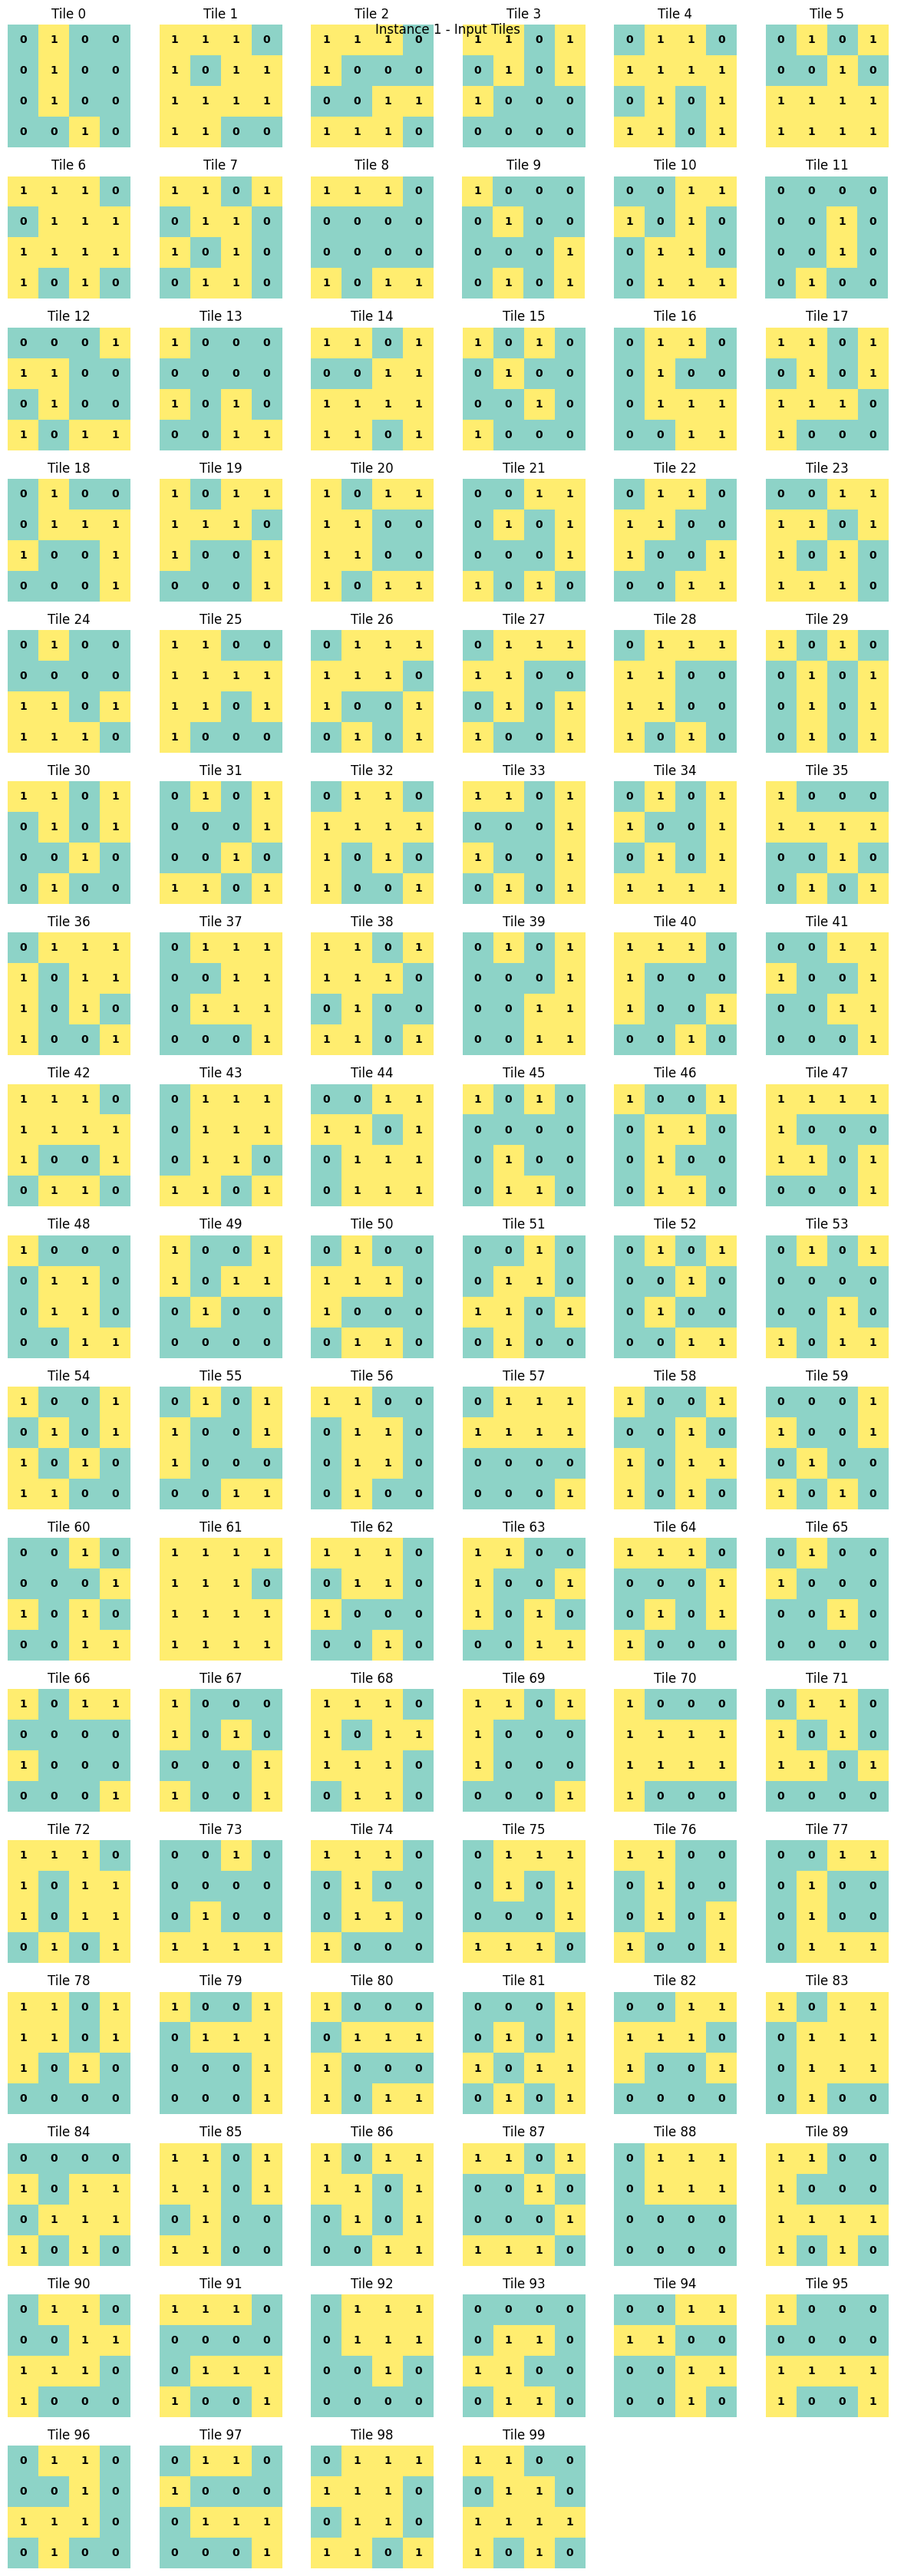


--------------------------------------------------
Neural Solver Solution
--------------------------------------------------
Validation: ✓ VALID
Canvas size (M): 35
Placed tiles: 100/100


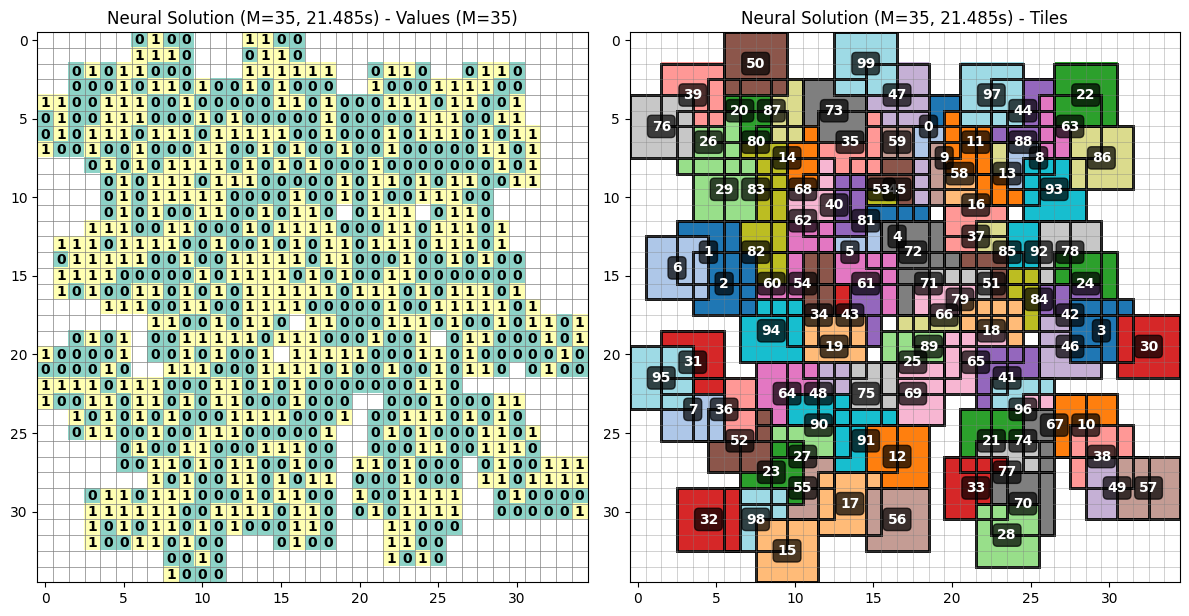

Solution time: 21.485s
Status: ok

--------------------------------------------------
Neural-Beam3 Solver Solution
--------------------------------------------------
Validation: ✓ VALID
Canvas size (M): 33
Placed tiles: 100/100


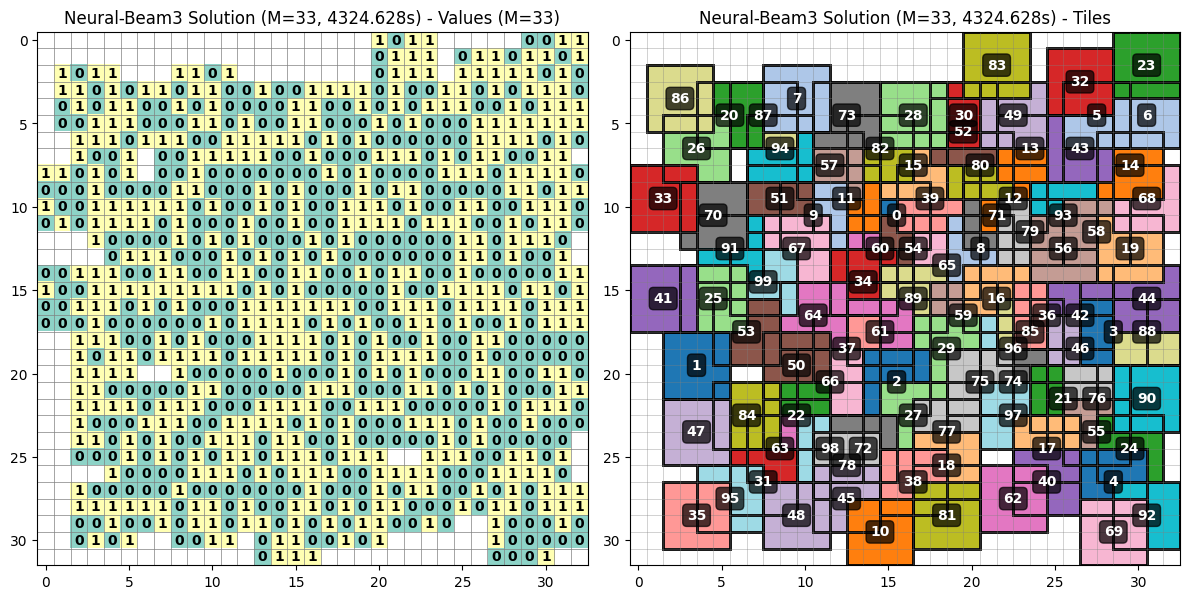

Solution time: 4324.628s
Status: ok

--------------------------------------------------
Greedy-min_bbox Solver Solution
--------------------------------------------------
Validation: ✓ VALID
Canvas size (M): 39
Placed tiles: 100/100


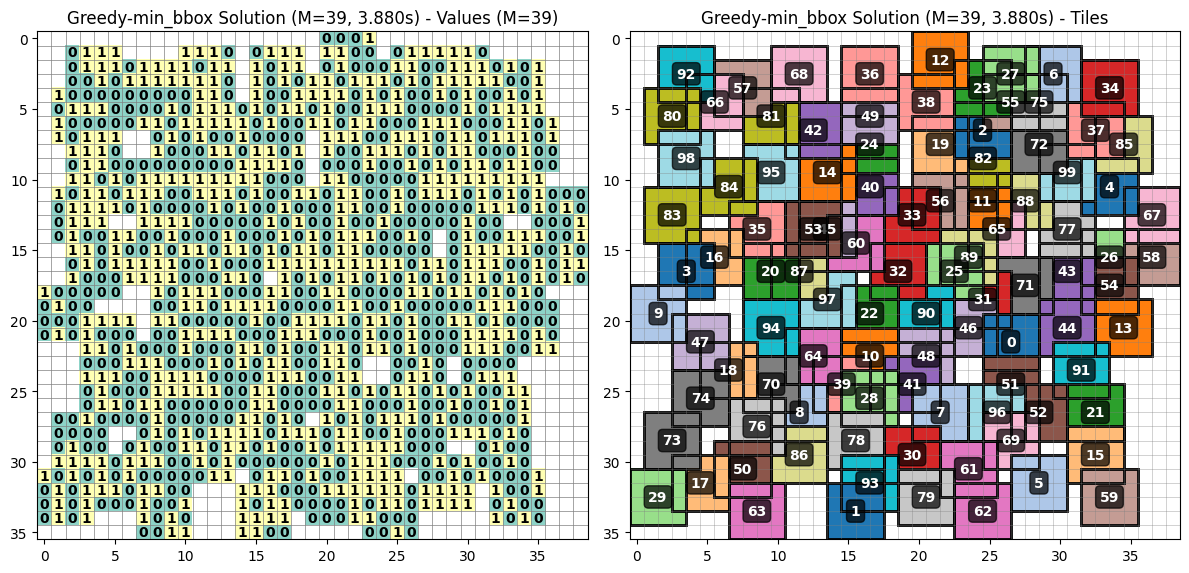

Solution time: 3.880s
Status: ok


In [ ]:
for instance_id, (tiles, instance_results) in enumerate(zip(test_instances, all_results)):
    print(f"\n{'='*80}")
    print(f"VALIDATION & VISUALIZATION - INSTANCE {instance_id + 1}")
    print(f"{'='*80}")
    
    # Show input tiles
    print(f"\nInput tiles for instance {instance_id + 1}:")
    fig, axes = visualize_tiles(tiles, f"Instance {instance_id + 1} - Input Tiles", max_cols=6)
    plt.show()
    
    for method_name, result in instance_results.items():
        if "error" in result:
            print(f"\n{result['method']} Solver: FAILED - {result['error']}")
            continue
        
        print(f"\n{'-'*50}")
        print(f"{result['method']} Solver Solution")
        print(f"{'-'*50}")
        
        # Check if this is a failed solution (empty placements but claiming success)
        is_empty_solution = len(result['placements']) == 0
        
        if is_empty_solution:
            status = result.get('status', 'unknown')
            if status == 'ok':
                print(f"⚠️  Solver reported 'ok' but found no solution (likely timed out)")
            else:
                print(f"❌ Solver failed to find a solution (status: {status})")
        
        # Validate solution
        validation = validate_solution(tiles, result["placements"], CONFIG["alphabet"])
        
        print(f"Validation: {'✓ VALID' if validation['valid'] else '✗ INVALID'}")
        print(f"Canvas size (M): {validation['canvas_size']}")
        print(f"Placed tiles: {validation['num_placed_tiles']}/{len(tiles)}")
        
        if not validation['valid']:
            if validation.get('error'):
                print(f"❌ Error: {validation['error']}")
            else:
                num_conflicts = validation.get('num_conflicts', 0)
                print(f"⚠️  Conflicts: {num_conflicts}")
                conflicts = validation.get('conflicts', [])
                for conflict in conflicts[:3]:  # Show first 3 conflicts
                    print(f"  - Position {conflict['position']}: expected {conflict['expected']}, found {conflict['found']} (tile {conflict['tile_id']})")
                if len(conflicts) > 3:
                    print(f"  - ... and {len(conflicts) - 3} more conflicts")
        
        # Visualize solution (even if empty, for completeness)
        title = f"{result['method']} Solution (M={result['best_m']}, {result['time']:.3f}s)"
        if is_empty_solution:
            title += " - NO SOLUTION FOUND"
        
        fig, axes = visualize_solution(tiles, result["placements"], CONFIG["alphabet"], 
                                     title=title, figsize=(12, 6))
        plt.show()
        
        print(f"Solution time: {result['time']:.3f}s")
        print(f"Status: {result.get('status', 'N/A')}")
        
        # Additional analysis for empty solutions
        if is_empty_solution:
            print(f"🔍 Analysis: The {result['method']} solver spent {result['time']:.1f}s but didn't place any tiles.")
            if result['time'] > 25:  # Assume timeout if > 25s
                print(f"   This likely indicates the problem was too difficult and the solver timed out.")

## Aggregate Results and Analysis


AGGREGATE RESULTS ANALYSIS

Greedy-min_bbox Solver:
  Successful runs: 1/1
  Best M - Mean: 39.00 ± 0.00
         Range: [39, 39]
  Time   - Mean: 3.880s ± 0.000s

Neural Solver:
  Successful runs: 1/1
  Best M - Mean: 35.00 ± 0.00
         Range: [35, 35]
  Time   - Mean: 21.485s ± 0.000s

Neural-Beam3 Solver:
  Successful runs: 1/1
  Best M - Mean: 33.00 ± 0.00
         Range: [33, 33]
  Time   - Mean: 4324.628s ± 0.000s


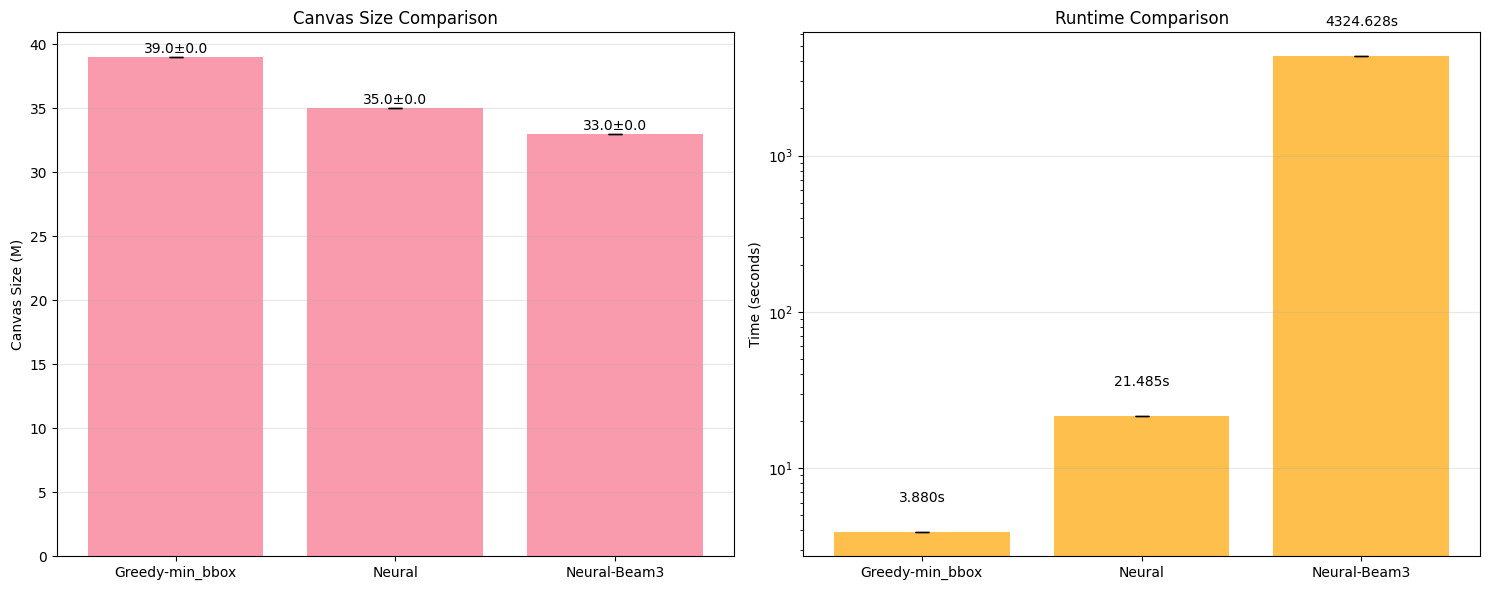


Testing completed for 1 instances!


In [ ]:
print(f"\n{'='*80}")
print("AGGREGATE RESULTS ANALYSIS")
print(f"{'='*80}")

# Collect method names
method_names = set()
for result in all_results:
    method_names.update(result.keys())

# Analysis data for plotting
method_stats = {}

for method in sorted(method_names):
    valid_results = []
    errors = 0
    
    for result in all_results:
        if method in result:
            if "error" not in result[method]:
                valid_results.append(result[method])
            else:
                errors += 1
    
    if valid_results:
        best_ms = [r["best_m"] for r in valid_results]
        times = [r["time"] for r in valid_results]
        
        method_stats[method] = {
            "name": valid_results[0]['method'],
            "successful_runs": len(valid_results),
            "errors": errors,
            "best_ms": best_ms,
            "times": times,
            "mean_m": np.mean(best_ms),
            "std_m": np.std(best_ms),
            "min_m": min(best_ms),
            "max_m": max(best_ms),
            "mean_time": np.mean(times),
            "std_time": np.std(times)
        }
        
        print(f"\n{valid_results[0]['method']} Solver:")
        print(f"  Successful runs: {len(valid_results)}/{CONFIG['test_size']}")
        if errors > 0:
            print(f"  Errors: {errors}")
        print(f"  Best M - Mean: {np.mean(best_ms):.2f} ± {np.std(best_ms):.2f}")
        print(f"         Range: [{min(best_ms)}, {max(best_ms)}]")
        print(f"  Time   - Mean: {np.mean(times):.3f}s ± {np.std(times):.3f}s")
    else:
        print(f"\n{method} Solver: No successful runs")

# Create performance comparison plots
if len(method_stats) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Canvas size comparison
    methods = list(method_stats.keys())
    means = [method_stats[m]['mean_m'] for m in methods]
    stds = [method_stats[m]['std_m'] for m in methods]
    names = [method_stats[m]['name'] for m in methods]
    
    bars1 = ax1.bar(names, means, yerr=stds, capsize=5, alpha=0.7)
    ax1.set_ylabel('Canvas Size (M)')
    ax1.set_title('Canvas Size Comparison')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars1, means, stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.1,
                f'{mean:.1f}±{std:.1f}', ha='center', va='bottom')
    
    # Plot 2: Time comparison
    times_mean = [method_stats[m]['mean_time'] for m in methods]
    times_std = [method_stats[m]['std_time'] for m in methods]
    
    bars2 = ax2.bar(names, times_mean, yerr=times_std, capsize=5, alpha=0.7, color='orange')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Runtime Comparison')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_yscale('log')  # Log scale for time comparison
    
    # Add value labels on bars
    for bar, mean, std in zip(bars2, times_mean, times_std):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height * 1.5,
                f'{mean:.3f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Box plots for detailed distribution analysis
    if CONFIG['test_size'] > 2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Box plot for canvas sizes
        canvas_data = [method_stats[m]['best_ms'] for m in methods]
        ax1.boxplot(canvas_data, labels=names)
        ax1.set_ylabel('Canvas Size (M)')
        ax1.set_title('Canvas Size Distribution')
        ax1.grid(axis='y', alpha=0.3)
        
        # Box plot for times
        time_data = [method_stats[m]['times'] for m in methods]
        ax2.boxplot(time_data, labels=names)
        ax2.set_ylabel('Time (seconds)')
        ax2.set_title('Runtime Distribution')
        ax2.set_yscale('log')
        ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print(f"\nTesting completed for {CONFIG['test_size']} instances!")

## Export Results (Optional)

In [ ]:
# Save results to CSV files (optional)
save_to_csv = False  # Set to True if you want to save results

if save_to_csv:
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare CSV data
    csv_data = []
    
    for instance_idx, instance_results in enumerate(all_results):
        for method_name, result in instance_results.items():
            row = {
                'timestamp': datetime.now().isoformat(),
                'instance_id': instance_idx,
                'method': result.get('method', method_name),
                'T': CONFIG['T'],
                'n': CONFIG['n'],
                'alphabet': CONFIG['alphabet'],
                'seed': CONFIG['seed'] + instance_idx,
                'best_m': result.get('best_m', None),
                'time_seconds': result.get('time', None),
                'status': result.get('status', 'error' if 'error' in result else 'unknown'),
                'error_message': result.get('error', ''),
                'checkpoint': CONFIG.get('checkpoint', ''),
                'temperature': CONFIG.get('temperature', ''),
                'greedy_inference': CONFIG.get('greedy_inference', '')
            }
            csv_data.append(row)
    
    # Save to CSV
    csv_path = results_dir / f"notebook_test_results_{timestamp}.csv"
    if csv_data:
        fieldnames = csv_data[0].keys()
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(csv_data)
        print(f"Results saved to {csv_path}")
    
    # Save summary
    summary_data = []
    for method_name, stats in method_stats.items():
        summary_row = {
            'timestamp': datetime.now().isoformat(),
            'method': stats['name'],
            'T': CONFIG['T'],
            'n': CONFIG['n'],
            'alphabet': CONFIG['alphabet'],
            'test_instances': CONFIG['test_size'],
            'successful_runs': stats['successful_runs'],
            'errors': stats['errors'],
            'best_m_mean': stats['mean_m'],
            'best_m_std': stats['std_m'],
            'best_m_min': stats['min_m'],
            'best_m_max': stats['max_m'],
            'time_mean': stats['mean_time'],
            'time_std': stats['std_time']
        }
        summary_data.append(summary_row)
    
    summary_path = results_dir / f"notebook_test_summary_{timestamp}.csv"
    if summary_data:
        fieldnames = summary_data[0].keys()
        with open(summary_path, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(summary_data)
        print(f"Summary saved to {summary_path}")
else:
    print("CSV export disabled. Set save_to_csv=True to enable.")

print("\nNotebook execution completed!")

CSV export disabled. Set save_to_csv=True to enable.

Notebook execution completed!


## Summary

This notebook provides:

1. **Comprehensive Testing**: Tests multiple solver approaches (Neural, Greedy, ACO, Exact)
2. **Solution Validation**: Checks for conflicts and validates tile placements
3. **Rich Visualization**: 
   - Input tile visualization
   - Solution grid showing values and tile boundaries
   - Performance comparison charts
4. **Statistical Analysis**: Mean, standard deviation, and distribution analysis
5. **Export Capabilities**: Optional CSV export for further analysis

Each solution is validated to ensure:
- No overlapping conflicts (matching values in overlap regions)
- Correct tile placement
- Proper canvas size calculation

The visualizations help understand:
- How tiles are arranged in the solution
- Which method produces more compact solutions
- Performance trade-offs between solution quality and runtime